# Рекомендация тарифов

## Введение

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Построим модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали (но всё равно проверим).

Построим модель с максимально большим значением *accuracy*.

## Импортируем используемые библиотеки

In [1]:
# импортируем библиотеки и необходимые методы из других библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

## Настроим стили и форматы вывода

In [2]:
# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# установим графическую тему для графиков и гистограмм
plt.style.use('seaborn')

# зададим размеры фигуры для вывода графиков и гистограмм
rcParams['figure.figsize'] = 15, 10

# настроим местоположение и размер шрифта для легенды графиков и гистограмм
rcParams['legend.loc'] = 'upper left'
rcParams['legend.fontsize'] = 14

## Зададим значения глобальных переменных

In [3]:
# случайное состояние для создания псевдослучайных последовательностей
MY_RANDOM_STATE = 1618034

## Прочитаем данные

In [4]:
# читаем данные в датафрейм с локального ПК, а если не получится, то из интернета
try:
    df = pd.read_csv('/datasets/users_behavior.csv', sep=',')
except:
    print('ОШИБКА: Данные о пользователях не были прочитаны, читаем из интернета!')
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv', sep=',')

## Предобработка данных

### Изучим общую информацию о данных

Выведем случайные 5 записей из набора данных, посмотрим основные характеристики датасета.

In [5]:
display(df.sample(5))
display(df.describe())

,calls,minutes,messages,mb_used,is_ultra
2832,22.00,168.44,16.00,"8,787.01",0
415,62.00,462.41,143.00,"16,369.41",1
1298,2.00,11.96,3.00,0.00,1
436,91.00,598.64,33.00,"28,524.79",1
1068,49.00,369.42,86.00,"8,483.11",0


,calls,minutes,messages,mb_used,is_ultra
count,"3,214.00","3,214.00","3,214.00","3,214.00","3,214.00"
mean,63.04,438.21,38.28,"17,207.67",0.31
std,33.24,234.57,36.15,"7,570.97",0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,"12,491.90",0.00
50%,62.00,430.60,30.00,"16,943.24",0.00
75%,82.00,571.93,57.00,"21,424.70",1.00
max,244.00,"1,632.06",224.00,"49,745.73",1.00


На пропуски данные проверять смысла нет, потому что во всех столбцах одинаковое количество записей (значение `count` во всх столбцах 3'214). Несложно заметить, что 31% пользователей используют тариф 'Ультра'. Данные об используемом тарифе (столбец `is_ultra`) будут использоваться в качестве целевого признака.

### Рассмотрим плотность значений

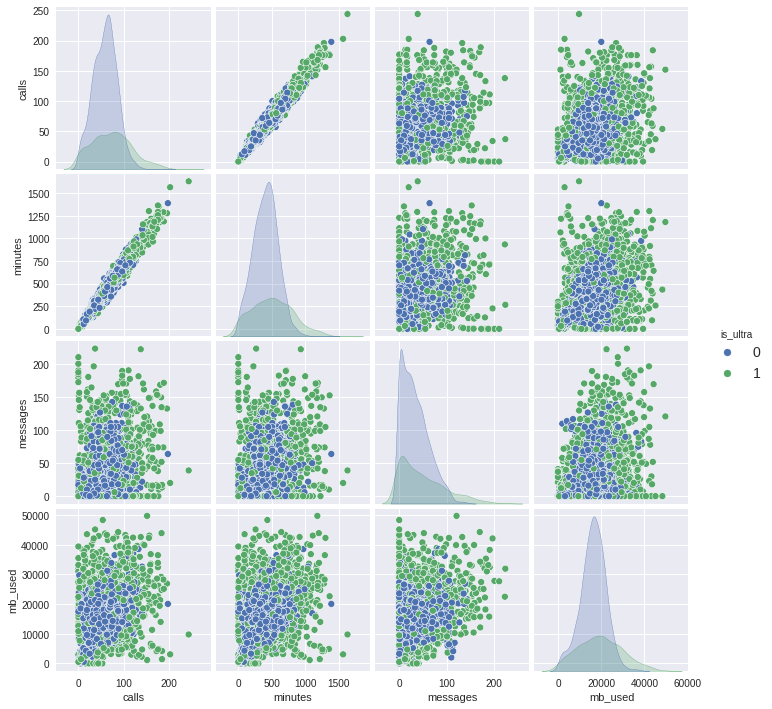

In [6]:
sns.pairplot(df, hue='is_ultra')
plt.show()

Пользователи тарифа "Смарт" отличаются избирательностью, они в большинстве случаев отправляют одинаковое (плюс-минус, конечно) количество сообщений, совершают похожее количество звонков и даже длительность их разговоров тоже максимально близка. Кроме того, стоит отметить очевидную корреляцию длительности звонка и количества звонков.

### Проверим данные на дубликаты

In [7]:
print('Количество дубликатов в данных:', df.duplicated().sum())

Количество дубликатов в данных: 0


### Проверим данные на мультиколлинеарность

Построим тепловую карту и проверим корреляцию признаков.

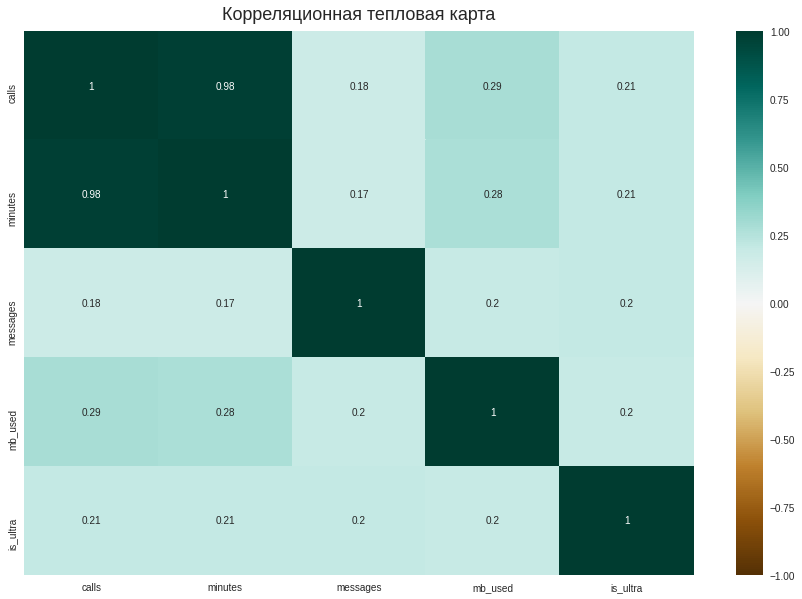

In [8]:
# построим тепловую карту корреляций
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Корреляционная тепловая карта', fontdict={'fontsize':18}, pad=12)
plt.show()

Очевидно, что суммарная длительность звонков и количество звонков мультиколлинеарные признаки, совместное использование таких признаков негативно влияет на методы машинного обучения.
Избавимся от столбца `calls`, так как длительность звонков более предпочтителный признак для модели.

In [9]:
# удалим столбец 'calls'
df = df.drop('calls', axis=1)

### Предварительные выводы

Нам предоставлены "чистые" данные - без пропусков, без дубликатов, с корректным названием столбцов. Получено общее представление о данных, определён столбец с целевыми признаками (`is_ultra`), можно выделять признаки и разбивать данные на выборки.

## Разобьём данные на выборки

### Выделим признаки для модели

In [10]:
# выделим из таблицы признаки для обучающей модели
features = df.drop('is_ultra', axis=1)

# выделим целевой признак
target = df['is_ultra']

### Разделим данные на выборки

60% от всего объёма выделим под обучающую выборку, 20% под валидационную (проверочную) и оставшиеся 20% под тестовую выборку.

In [11]:
# отделим обучающий (train) и тестовый (test) датасеты
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=MY_RANDOM_STATE, stratify=target)

# разделим датасеты на тестовый (test) и валидационный (valid)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=MY_RANDOM_STATE, stratify=target_test)

Проверим корректность разбивки данных.

In [12]:
# выведем сведения о разбивке данных
print(f'Данные разбиты в соотношении: '
      f'{len(features_train) / len(features):.1f}:'
      f'{len(features_valid) / len(features):.1f}:'
      f'{len(features_test) / len(features):.1f}\n')

# выведем пропорции классов целевого признака
print(f'Пропорция классов целевого признака (target) в генеральной совокупности: {sum(target == 0) / sum(target == 1):.2f}')
print(f'Пропорция классов в тренировочной выборке (target_train): {sum(target_train == 0) / sum(target_train == 1):.2f}')
print(f'Пропорция классов в валидационной выборке (target_valid): {sum(target_valid == 0) / sum(target_valid == 1):.2f}')
print(f'Пропорция классов в тестовой выборке (target_test): {sum(target_test == 0) / sum(target_test == 1):.2f}')

Данные разбиты в соотношении: 0.6:0.2:0.2

Пропорция классов целевого признака (target) в генеральной совокупности: 2.26
Пропорция классов в тренировочной выборке (target_train): 2.26
Пропорция классов в валидационной выборке (target_valid): 2.26
Пропорция классов в тестовой выборке (target_test): 2.26


В результате получили три набора данных:
1. Обучающий (на нём будем производить обучение моделей)
2. Валидационный (используется для проверки качества модели)
3. Тестовый (для оценки готовой модели)

Данные распределены равномерно (одинаковая пропорция нулей и единиц в целевом признаке всех выборок). Теперь мы готовы обучать, проверять и тестировать столько моделей машинного обучения, сколько будет необходимо для наших данных.

## Исследуем модели

### Модель решающего дерева

In [13]:
# создадим переменные для хранения лучшей модели
best_model = None
# лучшего результата точности предсказаний
best_result = 0
# и оптимальной глубины дерева
best_depth = 0

# переберём в цикле модели с различной глубиной дерева
for depth in range(1, 500):
    # создадим объект для классификации деревом решений с заданной глубиной дерева
    model = DecisionTreeClassifier(random_state=MY_RANDOM_STATE, max_depth=depth)
    # обучим модель на основе признаков и целевого признака из тренировочных данных
    model.fit(features_train, target_train)
    # посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid)
    # сравним результаты
    if result > best_result:
        # сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result
        # сохраним оптимальное значение глубины дерева
        best_depth = depth
        # сохраним лучшую модель
        best_model = model

# выведем результаты моделирования
print(f'Доля правильных ответов обучающей выборки: {best_result:.4f}')
print(f'Оптимальное значение глубины дерева: {best_depth}')

Доля правильных ответов обучающей выборки: 0.7994
Оптимальное значение глубины дерева: 6


Точность предсказания соответствует целевой. Попробуем исследовать другие модели, возможно, получим более высокую точность предсказаний.

### Модель логистической регрессии

In [14]:
# создадим объект для классификации модели логистической регрессии
model = LogisticRegression(random_state=MY_RANDOM_STATE, solver='lbfgs', max_iter=1000)
# обучим модель на основе тренировочный выборки
model.fit(features_train, target_train)
# посчитаем качество модели на валидационной выборке
result = model.score(features_valid, target_valid)

# выведем результаты моделирования
print(f'Доля правильных ответов обучающей выборки: {result:.4f}')

Доля правильных ответов обучающей выборки: 0.7512


Точность предсказаний ниже, чем у модели решающего дерева.

### Модель случайный лес

In [15]:
# сбросим значение лучшего результата
best_result = 0
# сбросим оптимальную глубину дерева
best_depth = 0
# создадим переменную для хранения оптимального количества деревьев
best_est = 0

# замерим время выполнения цикла
start_time = time.time()

# переберём в цикле модели с различным количеством деревьев
for est in range(1, 101):
    # и различным значением глубины дерева
    for depth in range(1, 7):
        # создадим объект для классификации с заданным количеством деревьев и глубины дерева
        model = RandomForestClassifier(random_state=MY_RANDOM_STATE, n_estimators=est, max_depth=depth)
        # обучим модель на основе тренировочный выборки
        model.fit(features_train, target_train)
        # посчитаем качество модели на валидационной выборке
        result = model.score(features_valid, target_valid)
        # сравним результаты
        if result > best_result:
            # сохраним наилучшее значение метрики accuracy на валидационных данных
            best_result = result
            # сохраним наилучшее значение количества деревьев
            best_est = est
            # сохраним оптимальное значение глубины дерева
            best_depth = depth
            # сохраним лучшую модель
            best_model = model

# выведем результаты моделирования
print(f'Доля правильных ответов обучающей выборки: {best_result:.4f}')
print(f'Оптимальное количество деревьев: {best_est}')
print(f'Оптимальная глубина дерева: {best_depth}')
print(f'Время выполнения: {(time.time() - start_time):,.2f} секунд')

Доля правильных ответов обучающей выборки: 0.8165
Оптимальное количество деревьев: 6
Оптимальная глубина дерева: 6
Время выполнения: 56.88 секунд


Из-за большого количества итераций код выполняется заметно долго, приблизительно от 52 до 59 секунд. Результат уже значительно лучше, но у нас в арсенале есть ещё один интересный алгоритм (на самом деле алгоритмов для решения задач классификации намного больше, за рамками этого исследования они были проверены и результаты оказались не столь впечатляющими, поэтому нет смысла углубляться в их исследование).

### Модель градиентного бустинга

In [16]:
# сбросим значение лучшего результата
best_result = 0
# создадим переменную для хранения оптимального количества итераций
best_est = 0

# переберём в цикле модели с различным количеством итераций
for est in range(1, 101):
    # создадим объект для классификации
    model = GradientBoostingClassifier(random_state=MY_RANDOM_STATE, n_estimators=est)
    # обучим модель на основе тренировочный выборки
    model.fit(features_train, target_train)
    # посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid)
    # сравним результаты
    if result > best_result:
        # сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result
        # сохраним наилучшее значение итераций
        best_est = est
        # сохраним лучшую модель
        best_model = model

# выведем результаты моделирования
print(f'Доля правильных ответов обучающей выборки: {best_result:.4f}')
print(f'Оптимальное количество итераций: {best_est}')

Доля правильных ответов обучающей выборки: 0.8243
Оптимальное количество итераций: 75


Как видим, эта модель дала наилучший результат.

### Выводы исследования качества моделей

В результате проведённых исследований, мы получили оптимальную модель на основе алгоритма градиентного бустинга, также выявили оптимальные гиперпараметры для этой модели. Доля правильных ответов обучающей выборки составила **0,8243**. Теперь можно опробовать получившуюся модель на тестовой выборке и проверить её на переобучение.

## Проверим качество модели на тестовой выборке

Получим предсказания на тестовой выборке, рассчитаем метрики качества модели.

In [17]:
# получим предсказания модели на основе тестовой выборки
predictions = best_model.predict(features_test)
# посчитаем качество модели на тестовой выборке
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)

# выведем результаты моделирования
print(f'Доля правильных ответов для модели градиентного бустинга на тестовой выборке: {accuracy:.4f}')
print(f'Точность для модели градиентного бустинга на тестовой выборке: {precision:.4f}')
print(f'Полнота для модели градиентного бустинга на тестовой выборке: {recall:.4f}')

На тестовой выборке модель показала близкое значение `accuracy` к значению на валидационной выборке, значит модель не переобучена и может быть рекомендована к дальнейшему коммерческому использованию.

## (бонус) Проверим модели на адекватность

Создадим baseline модель с помощью Dummy-классификатора. Рассчитаем для этой модели метрику `accuracy` и сравним её с нашей моделью.

In [18]:
# создадим baseline модель с помощью Dummy-классификатора
dc = DummyClassifier(strategy='most_frequent', random_state=MY_RANDOM_STATE)
dc.fit(features_train, target_train)
dc_pred = dc.predict(features_test)
dc_accuracy= accuracy_score(target_test, dc_pred)

# выведем результаты моделирования
print(f'Доля правильных ответов для модели Dummy-классификатора на тестовой выборке: {dc_accuracy:.4f}')

Доля правильных ответов для модели Dummy-классификатора на тестовой выборке: 0.6936


Доля правильных ответов нашей модели значительно выше, чем у baseline модели.

## Общий вывод исследования модели для задачи классификации

В результате проведённой работы были исследованы несколько моделей с различными алгоритмами классификации:
1. Дерево решений
2. Логистическая регрессия
3. Случайный лес
4. Градиентного бустинга

Алгоритмы 'Дерево решений', 'Градиентный бустинг' и 'Случайный лес' исследовались с различными гиперпараметрами для получения наиболее точной модели предсказаний.
В результате самые лучшие результаты показал алгоритм 'Градиентный бустинг', с долей правильных ответов на валидационной выборке **0.8243**.
Тестирование этиой модели на тестовой выборке дало результат `accuracy` **0.8212**. Результаты исследования приведены в таблице:

Метрика      | Значение
----------- | :-----------------:
`accuracy`  | 0.8212
`precision` | 0.7733
`recall`    | 0.5888

Исследование закончено, лучшая модель определена, качество модели оценено.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гиперпараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
